In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16 as PretrainedModel, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

In [3]:
from glob import glob
import sys, os

In [4]:
IMAGE_SIZE=[200,200]

In [5]:
train_path='D:/ML/Datasets/Food-5K/train'
valid_path='D:/ML/Datasets/Food-5K/test'

In [6]:
image_files=glob(train_path+'/*/*.jpg')
valid_files=glob(valid_path+'/*/*.jpg')

In [7]:
print(len(image_files), len(valid_files))

3000 1000


In [8]:
folders=glob(train_path+'/*')
folders

['D:/ML/Datasets/Food-5K/train\\food', 'D:/ML/Datasets/Food-5K/train\\nonfood']

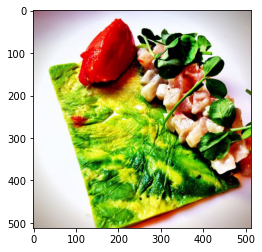

In [9]:
plt.imshow(image.load_img(np.random.choice(image_files)))
plt.show()

In [10]:
ptm=PretrainedModel(input_shape=IMAGE_SIZE+[3], weights='imagenet', include_top=False)

In [11]:
x=Flatten()(ptm.output) #to flatten the output or feature vector we get from cnn

In [12]:
model=Model(inputs=ptm.input, outputs=x)

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0     

In [14]:
gen=ImageDataGenerator(preprocessing_function=preprocess_input)
#no augmentation in generator

In [30]:
batch_size=128

train_generator=gen.flow_from_directory(
    train_path,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    class_mode='binary',
)

valid_generator=gen.flow_from_directory(
    valid_path,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    class_mode='binary',
    )

Found 3000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [31]:
Ntrain=len(image_files)
Nvalid=len(valid_files)
Ntrain, Nvalid

(3000, 1000)

In [32]:
feat=model.predict(np.random.random([1]+IMAGE_SIZE+[3]))  #generating random data of image with given dimension
D=feat.shape[1]
D

18432

In [33]:
[1]+IMAGE_SIZE+[3]

[1, 200, 200, 3]

In [34]:
feat.shape

(1, 18432)

In [35]:
x_train=np.zeros((Ntrain, D))
y_train=np.zeros((Ntrain))
x_valid=np.zeros((Nvalid, D))
y_valid=np.zeros((Nvalid))
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((3000, 18432), (3000,), (1000, 18432), (1000,))

In [36]:
# populate X_train and Y_train
i=0
for x,y in train_generator:
    
    #get_features
    features=model.predict(x)
    
    #size of the batch (may not always be batch_size)
    sz=len(y)
    
    #assign to X_train and Y_train
    x_train[i:i+sz]=features
    y_train[i:i+sz]=y
    
    #increement i
    i+=sz
    print(i)
    
    if i>= Ntrain:
        print('breaking now')
        break
        
print(i)

128
256
384
512
640
768
896
1024
1152
1280
1408
1536
1664
1792
1920
2048
2176
2304
2432
2560
2688
2816
2944
3000
breaking now
3000


In [37]:
# populate x_valid and y_valid
i=0
for x, y in valid_generator:
    features=model.predict(x)
    
    sz=len(y)
    
    x_valid[i:i+sz]=features
    y_valid[i:i+sz]=y
    
    i+=sz
    print(i)
    
    if i>=Nvalid:
        print("breaking now")
        break
        
print(i)

128
256
384
512
640
768
896
1000
breaking now
1000


In [38]:
x_train.max(), x_train.min()

(650.8260498046875, 0.0)

In [25]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()

x_train2=scaler.fit_transform(x_train)
x_valid2=scaler.transform(x_valid)

In [30]:
from sklearn.linear_model import LogisticRegression
logr=LogisticRegression()
logr.fit(x_train2, y_train)
print(logr.score(x_train2, y_train)*100)
print(logr.score(x_valid2, y_valid)*100)

100.0
97.89999999999999


In [31]:
i=Input(shape=(D,))
x=Dense(1, activation='sigmoid')(i)
linearmodel=Model(i,x)

In [34]:
linearmodel.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

In [35]:
r=linearmodel.fit(x_train, y_train, batch_size=128, epochs=10, validation_data=(x_valid, y_valid))

Epoch 1/10
24/24 [==============================] - 1s 27ms/step - loss: 1.6943 - accuracy: 0.9050 - val_loss: 0.2519 - val_accuracy: 0.9770
Epoch 2/10
24/24 [==============================] - 0s 16ms/step - loss: 0.1115 - accuracy: 0.9907 - val_loss: 0.4514 - val_accuracy: 0.9650
Epoch 3/10
24/24 [==============================] - 0s 17ms/step - loss: 0.0662 - accuracy: 0.9907 - val_loss: 0.2048 - val_accuracy: 0.9870
Epoch 4/10
24/24 [==============================] - 0s 17ms/step - loss: 0.0045 - accuracy: 0.9990 - val_loss: 0.2048 - val_accuracy: 0.9860
Epoch 5/10
24/24 [==============================] - 0s 18ms/step - loss: 1.2533e-05 - accuracy: 1.0000 - val_loss: 0.2072 - val_accuracy: 0.9850
Epoch 6/10
24/24 [==============================] - 0s 17ms/step - loss: 6.6128e-06 - accuracy: 1.0000 - val_loss: 0.2072 - val_accuracy: 0.9850
Epoch 7/10
24/24 [==============================] - 0s 15ms/step - loss: 5.0725e-06 - accuracy: 1.0000 - val_loss: 0.2070 - val_accuracy: 0.9850
E

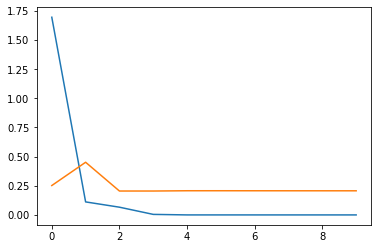

In [36]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.show()

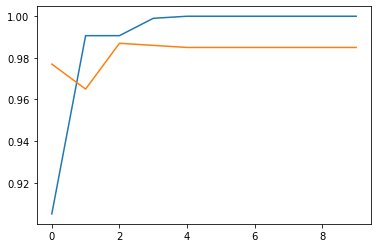

In [37]:
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.show()